# Flow Calculation
In this notebook, we present the approach we used to estimate the incoming and outgoing water flow rates of the two tanks in our system.

### Detection of the water volume in an image
TODO

Text(0.5,1,"Water volume in the tank given the ball's height")

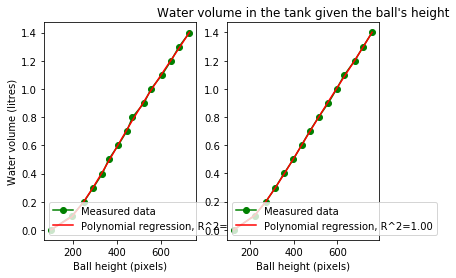

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


def load_data(csv_file):
    """
    Load the x and y values saved in a csv file in two numpy arrays.
    
    Args:
        csv_file: The path to the file that must be read.
        
    Returns:
        A tuple of two numpy arrays containing the x and y values extracted
        from the input .csv file.
    """
    data = []
    with open(csv_file, 'r') as input_data:
        for line in input_data:
            line = line.split(', ')
            data.append((float(line[0]), float(line[1])))

        x, y = zip(*sorted(data))
        x, y = np.array(x).reshape(-1, 1), np.array(y).reshape(-1, 1)
        return (x, y)
    
# The traces of the water volume given the ball height for the left and right tank
# are loaded.
x_left, y_left = load_data('files/height_volume_left.csv')
x_right, y_right = load_data('files/height_volume_right.csv')

# Polynomial regressions are fit on the traces.
x_powers_left = np.c_[x_left, np.square(x_left), np.power(x_left, 3), np.power(x_left, 4)]
x_powers_right = np.c_[x_right, np.square(x_right), np.power(x_right, 3), np.power(x_right, 4)]

reg_left = LinearRegression()
reg_left.fit(x_powers_left, y_left)
y_pred_left = reg_left.predict(x_powers_left)
r2_left = r2_score(y_left, y_pred_left)

reg_right = LinearRegression()
reg_right.fit(x_powers_right, y_right)
y_pred_right = reg_right.predict(x_powers_right)
r2_right = r2_score(y_right, y_pred_right)

# Plot of the results.
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.plot(x_left, y_left, '-og')
ax1.plot(x_left, y_pred_left, '-r')
ax1.legend(["Measured data",
            "Polynomial regression, R^2={:.2f}".format(r2_left)])
plt.xlabel('Ball height (pixels)')
plt.ylabel('Water volume (litres)')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(x_right, y_right, '-og')
ax2.plot(x_right, y_pred_right, '-r')
ax2.legend(["Measured data",
            "Polynomial regression, R^2={:.2f}".format(r2_right)])
plt.xlabel('Ball height (pixels)')
plt.title("Water volume in the tank given the ball's height")

### Volume/time traces
TODO

Text(0.5,0,'time (seconds)')

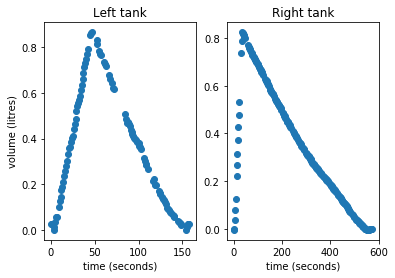

In [4]:
# The traces of the water volume over time for the left and right tank
# are loaded.
xflow_left, yflow_left = load_data('files/time_volume_left.csv')
xflow_right, yflow_right = load_data('files/time_volume_right.csv')

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.plot(xflow_left, yflow_left, 'o')
ax1.set_title("Left tank")
plt.xlabel('time (seconds)')
plt.ylabel('volume (litres)')
ax2 = fig.add_subplot(1,2,2)
ax2.plot(xflow_right, yflow_right, 'o')
ax2.set_title("Right tank")
plt.xlabel('time (seconds)')

### Regression on the traces
TODO

### Estimation of the flow rates
TODO